# Classifying skin lesions using a convolutional neural network

The goal of this assignment is to design and implement a deep learning model
able to determine the category of a skin lesion from a dermoscopic image.

This is a _multiclass classification_ problem where the inputs are RGB
images; therefore, the most natural approach is to use a Convolutional Neural
Network (CNN) for classification.

In this document I will go through the different steps of the data analysis
pipeline, explaining the reasons behind the choices I made and their
consequences on the results of the experiments.

#### Summary

This report is organized as follows:  

1. [**Data exploration**](#Data-exploration)
1. [**(brief) Literature review**](#Literature-review)
1. [**Experiment design**](#Experiment-design)
1. [**Implementation details**](#Implementation-details)
1. [**Results**](#Results)
1. [**Conclusions**](#Conclusions)

## Data exploration
[back to top](#Summary)

#### Imports

In [3]:
%matplotlib inline

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [32]:
import os
import sys

In [7]:
import numpy as np

In [27]:
import torchvision.transforms as transforms
import PIL

In [33]:
# Add parent folder to system path to allow loading modules
sys.path.append("..")

Set up folders

In [8]:
DATA_FOLDER = "../data"
ANNOTATION_FILE_NAME = "HAM10000_metadata.csv"
LABEL_COLUMN = 'dx'

### Read annotations

In [9]:
annotation_df = pd.read_csv(os.path.join(DATA_FOLDER, ANNOTATION_FILE_NAME))

In [10]:
annotation_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

## Data exploration
[back to top](#Summary)

The very first step in most data analysis pipelines consists in
_looking at the dataset_ and trying to understand its characteristics, in order
to make the appropriate decisions when designing the experiments.

The following table and plot show the number of samples present in the dataset for each
class.

In [25]:
# Use sample to get a bit more varied set of examples
annotation_df.sample(frac=1.0).head(n=15)

,lesion_id,image_id,dx,dx_type,age,sex,localization
2364,HAM_0003862,ISIC_0032775,vasc,histo,45.0,male,upper extremity
9867,HAM_0000688,ISIC_0026720,akiec,histo,75.0,male,lower extremity
6962,HAM_0000230,ISIC_0032150,nv,histo,50.0,female,lower extremity
875,HAM_0003881,ISIC_0031893,bkl,consensus,70.0,female,face
5479,HAM_0003292,ISIC_0029173,nv,follow_up,65.0,male,abdomen
560,HAM_0006240,ISIC_0030188,bkl,histo,80.0,male,upper extremity
4524,HAM_0004626,ISIC_0026904,nv,follow_up,55.0,male,upper extremity
1800,HAM_0002841,ISIC_0032982,mel,histo,20.0,male,back
5335,HAM_0002270,ISIC_0031607,nv,follow_up,45.0,female,lower extremity
1533,HAM_0000321,ISIC_0032733,mel,histo,70.0,male,back


In [79]:
annotation_df.groupby(LABEL_COLUMN)['age'].describe()

,count,mean,std,min,25%,50%,75%,max
dx,,,,,,,,
akiec,327.0,66.529052,11.476232,30.0,60.0,70.0,75.0,85.0
bcc,514.0,66.828794,13.656959,20.0,60.0,70.0,75.0,85.0
bkl,1089.0,64.283747,14.120715,0.0,55.0,65.0,75.0,85.0
df,115.0,53.043478,13.551326,25.0,45.0,50.0,65.0,80.0
mel,1111.0,60.679568,15.189847,5.0,50.0,60.0,70.0,85.0
nv,6660.0,46.477477,15.183275,0.0,35.0,45.0,55.0,85.0
vasc,142.0,51.373239,21.644651,0.0,40.0,55.0,70.0,85.0


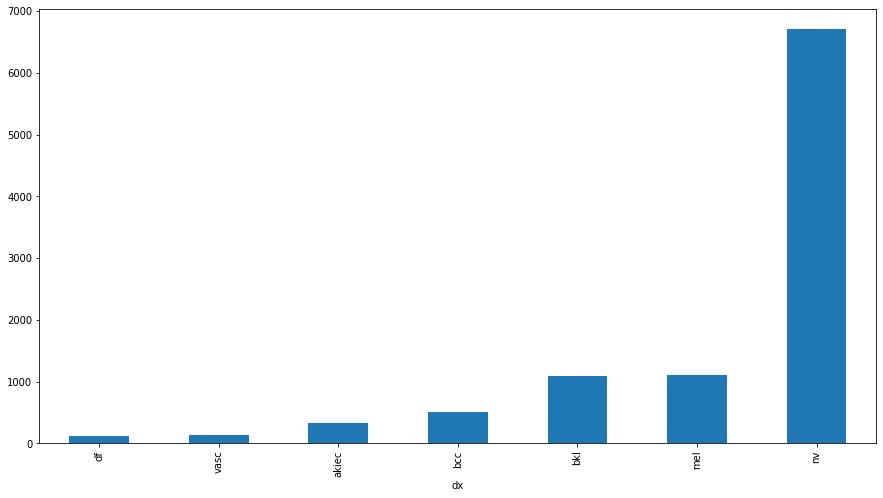

In [9]:
plt.figure(figsize=(15,8))
annotation_df.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(kind='bar')

This plot clearly shows that the dataset is *heavily inbalanced*: the most
represented class is by far **nv**, corresponding to *benign melanocytic nevi*, with
6660 samples, while the least represented class, **df** (*dermatofibromas*), has
only 115 samples in this dataset.


This was to be expected, since medical datasets often contain many more samples
of a given feature (in this case, skin lesions) *not* affected by a disease than
samples presenting signs of a medical condition.


Apart from the evident class inbalance, some of the classes (most of them,
actually) have a very small number of samples in absolute terms, which may lead
to severe problems in the training process, unless properly addressed.


These are crucial aspects of this particular dataset, which will need to be
taken into consideration when choosing the parameters for the training process
(hyperparameters and overall training strategy). All of the choices made to
address the issues discussed above are explained in detail in section
[experiment design](#Experiment-design).

### Visuzlize sample images

Since the input are RGB images, visualizing a few of them for each class might
provide some useful insight.

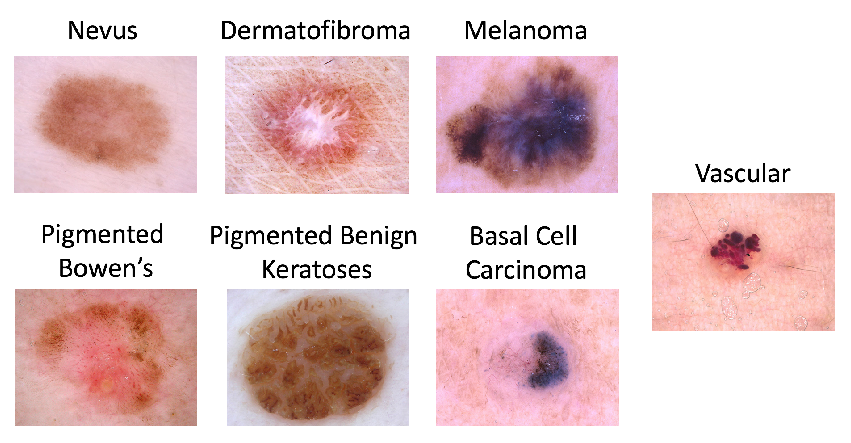

In [29]:
sample_image = plt.imread("../lesions.png")
plt.figure(figsize=(15,8))
plt.axis('off')
plt.imshow(sample_image);

Display a few images from the dataset on a grid in order to visually check their characteristics

In [34]:
from lib.dataset import HAM10000, create_train_val_split, read_meta_data

In [35]:
train_ids, val_ids = create_train_val_split(DATA_FOLDER, 0.8, 0.2)

In [68]:
# Order so that classes that get confused are shown close to one another
class_labels = ['akiec', 'bkl', 'bcc', 'df', 'mel', 'nv', 'vasc']

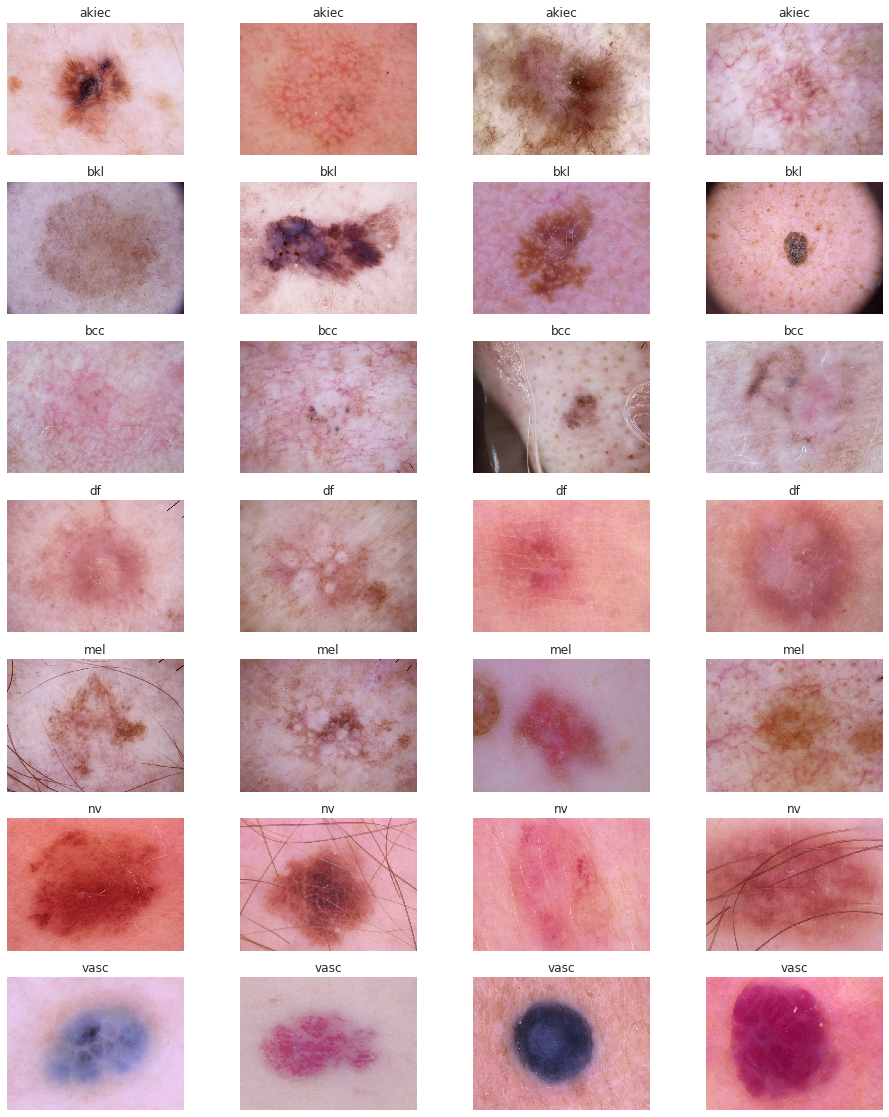

In [88]:
n_rows = len(class_labels)
n_cols = 4

f, axes = plt.subplots(n_rows, n_cols, figsize=(16, 20))

for x, l in enumerate(class_labels):
    samples4 = annotation_df[(annotation_df['dx'] == l)].sample(frac=1.0, random_state=9876).iloc[:4]
    for y, im_id in enumerate(samples4['image_id']):
        img = plt.imread(os.path.join(DATA_FOLDER, "{}.jpg".format(im_id)))
        axes[x, y].axis('off')
        axes[x, y].imshow(img)
        axes[x, y].set_title(l)

###### Literature review
[back to top](#Summary)

https://arxiv.org/pdf/1812.02316.pdf

## Experiment design
[back to top](#Summary)

The auxiliary function used to produce the training/validation splits takes a seed for the random number generator as input.

### Data augmentation

,lesion_id,image_id,dx,dx_type,age,sex,localization
1046,HAM_0001402,ISIC_0031558,bkl,consensus,50.0,female,upper extremity
390,HAM_0003420,ISIC_0024748,bkl,histo,45.0,male,abdomen
122,HAM_0000344,ISIC_0032972,bkl,histo,55.0,male,trunk
1074,HAM_0000452,ISIC_0029048,bkl,consensus,45.0,female,abdomen


In [38]:
# Load the dataset without any data augmentation, just to display samples from it
dataset_train_vanilla = HAM10000(DATA_FOLDER, train_ids, transforms=transforms.ToPILImage())

### Monitoring experiments

Tensorboard

#### Metrics

* Training/Validation Loss
* Training/Validation Accuracy
* Class specific metrics:
    * Precision
    * Recall
    * ROC AUC
    

In [ ]:
sys.path.append("..")
from main import get_data_augmentation_transforms

## Implementation details
[back to top](#Summary)

## Results
[back to top](#Summary)

In [81]:
from lib.utils import plot_tf_log

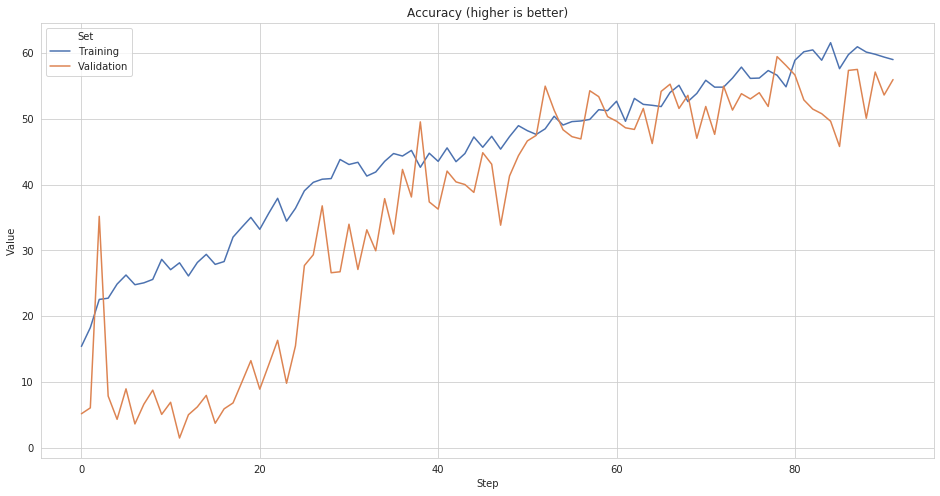

In [86]:
plt.figure(figsize=(16,8))
plot_tf_log(["../run6_train.csv", "../run6_val.csv"], "Accuracy (higher is better)")

Experiments have been performed on a PC with the following specs:

 * **CPU**: Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz
 * **RAM**: 32 GB
 * **OS**: Ubuntu 18.04
 * **GPU**: NVIDIA RTX 2080 TI GPU
 
Each "epoch" (considering both training and the forward pass on the whole validation set) took roughly 2:35.

## Conclusions
[back to top](#Summary)

### Future work

* Use additional data from other datasets
* Include additional information (age) however be sure not to fixate on that...
* Choose different values for the learning rate of layers deeper in the network (as opposed to those in the first layers)